In [ ]:
import numpy as np
import pandas as pd
from dateutil.parser import parse

from sklearn import preprocessing

train_path = './data/ft3_data/1206实验_TVOC_集成传感器.csv'
test_path = './data/ft3_data/1207实验_TVOC_集成传感器.csv'
csv_train = pd.read_csv(train_path,sep=",",encoding='gb2312',parse_dates=True, date_parser=parse,header=0)
csv_train.sort_index(axis=0,ascending=True)
scaler = preprocessing.StandardScaler()
labels_train = []
#[厨房,餐厅,儿童房,客厅]
#[1144800890,1144800897,1144800904,1144800896]
labels_train.append(np.array(csv_train.loc[:,["1144800904_PM2.5"]]))
#labels.append(np.array(csv_train.loc[:,["1144800890_CO2","1144800897_CO2","1144800904_CO2","1144800896_CO2"]]))
#labels.append(np.array(csv_train.loc[:,["1144800890_PM10","1144800897_PM10","1144800897_PM10","1144800897_PM10"]]))
labels_train = np.array(labels_train)
labels_train = np.array(labels_train).transpose(1,2,0)
print(labels_train.shape)
""" corr = np.corrcoef(labels)
dataframe = pd.DataFrame(corr)
print(dataframe) """
preds_train = np.array(csv_train.loc[:,["1144800896_PM2.5","1144800897_PM2.5"]])
preds_train = np.expand_dims(preds_train,axis=-1)


csv_test = pd.read_csv(test_path,sep=",",encoding='gb2312',parse_dates=True, date_parser=parse,header=0)
csv_test.sort_index(axis=0,ascending=True)
labels_test = []
#[厨房,餐厅,儿童房,客厅]
#[1144800890,1144800897,1144800904,1144800896]
labels_test.append(np.array(csv_test.loc[:,["1144800904_PM2.5"]]))
#labels.append(np.array(csv_train.loc[:,["1144800890_CO2","1144800897_CO2","1144800904_CO2","1144800896_CO2"]]))
#labels.append(np.array(csv_train.loc[:,["1144800890_PM10","1144800897_PM10","1144800897_PM10","1144800897_PM10"]]))
labels_test = np.array(labels_test)
labels_test = np.array(labels_test).transpose(1,2,0)
print(labels_test.shape)
""" corr = np.corrcoef(labels)
dataframe = pd.DataFrame(corr)
print(dataframe) """
preds_test = np.array(csv_test.loc[:,["1144800897_PM2.5","1144800896_PM2.5"]])
preds_test = np.expand_dims(preds_test,axis=-1)

#data = np.array(csv_train.iloc[:,:])

time_len = preds_train.shape[0]
enstep = 12
destep = 1
steps = 3
x = []
y = []
tx = []
ty = []
split_rr = int(labels_train.shape[0]//10)
train_input = labels_train[:9*split_rr]
train_label = preds_train[:9*split_rr]
time_train = train_input.shape[0]
test_input = labels_train[9*split_rr:]
test_label = preds_train[9*split_rr:]
time_test = test_input.shape[0]
for k in range(1,steps+1):
    for i in range(enstep*k,time_train-destep*k):
        x.append(train_input[i-enstep*k:i:k,:])
        y.append(train_label[i:i+destep*k:k,:])

for i in range(enstep,time_test-destep):
    tx.append(test_input[i-enstep:i,:])
    ty.append(test_label[i:i+destep,:])
x = np.array(x)
y = np.array(y)
tx = np.array(tx)
ty = np.array(ty)
print(x.shape,y.shape)
print(tx.shape,ty.shape)
train = [x,y]
valid = [tx,ty]
test = [tx,ty]

np.savez('./data/ft3_data/train.npz', x=train[0],y=train[1])
np.savez('./data/ft3_data/val.npz', x=valid[0],y=valid[1])
np.savez('./data/ft3_data/test.npz', x=test[0],y=test[1])

In [2]:
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import os


data_path = './data'
scaler = preprocessing.MinMaxScaler(feature_range=(0,200))
air_quality_data = pd.read_csv('{}/airquality.csv'.format(data_path))

# remove data from 1022 that with lot of null data
air_quality_data = air_quality_data[air_quality_data['station_id'] != 1022]
columns = ['PM25_Concentration', 'PM10_Concentration',
            'NO2_Concentration', 'CO_Concentration',
            'O3_Concentration', 'SO2_Concentration']
# pivot the data
pivot_air_data = air_quality_data.pivot(index='time', columns='station_id', values=columns)
# linear interpolate to fill the loss value
pivot_air_data1 = pivot_air_data.interpolate(method='linear').dropna()

air_quality_data = pivot_air_data1.stack(level=1).reset_index().sort_values(by=['station_id', 'time'])
input_data = []
index = []
#print(np.array(air_quality_data[(air_quality_data['station_id'] == 1001)].loc[:,'PM25_Concentration'].values).shape)
for i in range(1001,1036):
    #input_data.append(np.array(air_quality_data[(air_quality_data.station_id == i)].drop(['station_id', 'time'], axis=1).values))
    if i!=1022:
        index.append(i)
        input_data.append(np.array(air_quality_data[(air_quality_data.station_id == i)].loc[:,'PM25_Concentration'].values))
input_data = np.array(input_data)
print(input_data.shape)
corr = np.corrcoef(input_data)
#print(np.corrcoef(input_data))
dataframe = pd.DataFrame(corr,index=index,columns=index)
#dataframe.to_csv('corr.csv')
labels = (dataframe.mean(axis=0).sort_values(ascending=False)).iloc[:2]
labels_index = np.array(labels.index)
preds_index = []
#print(dataframe[>0.8])

for i in labels_index:
    dt = dataframe.loc[i]
    dt_index = np.array(dt[(dt>0.8) & (dt<1)].sort_values(ascending=False).index)[:5]
    preds_index.extend(dt_index)

preds_index = np.array(preds_index).reshape(-1)
preds_index = np.sort(preds_index)
for i in range(len(labels_index)):
    preds_index = np.delete(preds_index,np.where(preds_index==labels_index[i]))
preds_index = np.unique(preds_index)


###交换，少对多
m = preds_index
preds_index = labels_index
labels_index = m
print("labels:",labels_index)
print("preds:",preds_index)

input_data = []
label_data = []
for i in preds_index:
#for i in range(1018,1036):
    #input_data.append(np.array(air_quality_data[(air_quality_data.station_id == i)].drop(['station_id', 'time'], axis=1).values))
    if i !=1022:
        input_data.append(scaler.fit_transform(np.array(air_quality_data[(air_quality_data.station_id == i)].drop(['station_id', 'time'], axis=1).values)))
for i in labels_index:
    if i !=1022:
        label_data.append(scaler.fit_transform(np.array(air_quality_data[(air_quality_data.station_id == i)].drop(['station_id', 'time','PM10_Concentration','NO2_Concentration', 'CO_Concentration',
            'O3_Concentration', 'SO2_Concentration'], axis=1).values)))

""" for i in range(1018,1036):
    #input_data.append(np.array(air_quality_data[(air_quality_data.station_id == i)].drop(['station_id', 'time'], axis=1).values))
    if i !=1022:
        input_data.append(scaler.fit_transform(np.array(air_quality_data[(air_quality_data.station_id == i)].drop(['station_id', 'time'], axis=1).values)))
for i in range(1001,1018):
    if i !=1022:
        label_data.append(scaler.fit_transform(np.array(air_quality_data[(air_quality_data.station_id == i)].drop(['station_id', 'time','PM10_Concentration','NO2_Concentration', 'CO_Concentration',
            'O3_Concentration', 'SO2_Concentration'], axis=1).values))) """

input_data = np.array(input_data)
label_data = np.array(label_data) 
""" scl2 =  preprocessing.StandardScaler(with_mean=np.mean(input_data[0]),with_std=np.std(input_data[0]))
print(input_data[0])
print(scl2.inverse_transform(input_data[0])) """
input_data = input_data.transpose(1,0,2)
label_data = label_data.transpose(1,0,2)
enstep = 120
destep = 24
steps = 1
x = []
y = []
tx = []
ty = []
split_rr = int(input_data.shape[0]//10)
train_input = input_data[:9*split_rr]
train_label = label_data[:9*split_rr]
time_train = train_input.shape[0]
test_input = input_data[9*split_rr:]
test_label = label_data[9*split_rr:]
time_test = test_input.shape[0]
for k in range(1,steps+1):
    for i in range(enstep*k,time_train-destep*k):
        x.append(train_input[i+1-enstep*k:i+1:k,:])
        y.append(train_label[i:i+destep*k:k,:])

for i in range(enstep,time_test-destep):
    tx.append(test_input[i-(enstep-1):i+1,:])
    ty.append(test_label[i:i+destep,:])
x = np.array(x)
y = np.array(y)
tx = np.array(tx)
ty = np.array(ty)
print(x.shape,y.shape)
print(tx.shape,ty.shape)
train = [x,y]
valid = [tx,ty]
test = [tx,ty]
np.savez('./data/air_data/train.npz', x=train[0],y=train[1])
np.savez('./data/air_data/val.npz', x=test[0],y=test[1])
np.savez('./data/air_data/test.npz', x=test[0],y=test[1])

(34, 0)
labels: []
preds: [1001 1002]


c:\Users\10167\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\10167\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\10167\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\10167\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\10167\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by MinMaxScaler.

方太新数据集

In [4]:
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import os
from src.utils.scaler import StandardScaler, MinMaxScaler


data_path = './data/ft_data_origin'
#scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
#scaler = preprocessing.StandardScaler()
real_data = pd.read_csv('{}/real.csv'.format(data_path))
predict_data = pd.read_csv('{}/predict.csv'.format(data_path))
columns = ["time","CO2","TVOC","CH2O","PM2.5","humidity","temperature","PM10","PM1.0","LUX","MCU","noise"]
real_data.sort_index(axis=0,ascending=True)
predict_data.sort_index(axis=0,ascending=True)

""" real_train = scaler.fit_transform(np.array(real_data.drop(["time"],axis=1)))
predict_train = scaler.fit_transform(np.array(predict_data.loc[:,["PM2.5"]])) """
#predict_train = scaler.fit_transform(np.array(predict_data.loc[:,["PM2.5"]]))

#real_train = np.array(real_data.loc[:,["PM2.5"]],dtype=np.float64)
real_train = np.array(real_data.drop(["time"],axis=1),dtype=np.float64)
predict_train = np.array(predict_data.loc[:,["PM2.5"]],dtype=np.float64)

real_train  = np.expand_dims(real_train,axis=1)
predict_train  = np.expand_dims(predict_train,axis=1)
#print(real_train[:20],predict_train[:20])

time_len = predict_train.shape[0]
enstep = 120
destep = 24
steps = 1
x = []
y = []
y_=[]
tx = []
ty = []
split_rr = int(predict_train.shape[0]//10)
train_real = real_train[:8*split_rr]
train_predict = predict_train[:8*split_rr]
time_train =train_real.shape[0]
test_real = real_train[8*split_rr:]
test_predict = predict_train[8*split_rr:]
time_test = test_predict.shape[0]

print(test_predict.shape)

output_dim = test_real.shape[-1]
history = train_real.copy()
meann =[]
stdd = []

scalers = []

for i in range(output_dim):
    """ scalers.append(MinMaxScaler(mean=history[...,i].mean(),
                                    std=history[...,i].std())) """
    scalers.append(MinMaxScaler(min=history[..., i].min(),
                                    max=history[..., i].max()))

for i in range(output_dim):
    history[...,i] = scalers[i].transform(history[...,i])
print(history[:20])
print("real_train shape: {}".format(history.shape))
np.save('./data/ft_new_last/history.npy',history)
#print(history[:20])
#print("1111")
#print(train_real[:20])
#train_real = np.concatenate((real_train[:8*split_rr],real_train[8*split_rr:10*split_rr]))
#train_predict = np.concatenate((predict_train[:8*split_rr],predict_train[8*split_rr:10*split_rr]))

#print(real_train[:20],predict_train[:20])
for i in range(enstep*steps,time_train-destep):
    x.append(train_real[i-enstep*steps:i:steps,:])
    #x.append(train_real[i-enstep:i,:])
    #y.append(train_predict[i:i+destep*steps:steps,:])
    y_.append(train_predict[i-enstep*steps:i:steps,:])
    y.append(train_predict[i:i+destep,:])

for i in range(enstep*steps,time_test-destep):
    tx.append(test_real[i-enstep*steps:i:steps,:])
    #tx.append(test_real[i-enstep:i,:])
    #ty.append(test_predict[i:i+destep*steps:steps,:])
    ty.append(test_predict[i:i+destep,:])
x = np.array(x)
y = np.array(y)
y_ = np.array(y_)
tx = np.array(tx)
ty = np.array(ty)
print(x.shape,y.shape)
print(tx.shape,ty.shape)
train = [x,y,y_]
valid = [tx,ty]
test = [tx,ty]
xx = np.array(range(0,y.shape[0],1))
yy = y[:,0,0,0]

print(xx.shape,yy.shape)
plt.figure(dpi=800,figsize=(40,8))
plt.plot(xx,yy,linewidth=2,color='r')
plt.show()

np.savez('./data/ft_test/train.npz', x=train[0],y=train[1],y_=train[2])
np.savez('./data/ft_test/val.npz', x=test[0],y=test[1])
np.savez('./data/ft_test/test.npz', x=test[0],y=test[1])

(1759, 1, 1)
[[[0.25405405 0.45185185 0.45762712 0.00504032 0.         0.76525822
   0.00707786 0.00503525 0.41666667 0.89968652 0.29268293]]

 [[0.23783784 0.4        0.40677966 0.00504032 0.01196172 0.78403756
   0.00808898 0.00503525 0.41666667 0.86520376 0.29268293]]

 [[0.24324324 0.43703704 0.44067797 0.00504032 0.01435407 0.77464789
   0.00808898 0.00503525 0.41666667 0.87774295 0.29268293]]

 [[0.26486486 0.41481481 0.42372881 0.00604839 0.00956938 0.75117371
   0.00808898 0.0060423  0.41666667 0.91222571 0.29268293]]

 [[0.28648649 0.39259259 0.38983051 0.00604839 0.00717703 0.74178404
   0.00808898 0.00503525 0.41666667 0.92476489 0.31707317]]

 [[0.27027027 0.42222222 0.42372881 0.00604839 0.01435407 0.76056338
   0.00707786 0.00503525 0.41666667 0.89028213 0.29268293]]

 [[0.25405405 0.43703704 0.44067797 0.00705645 0.0215311  0.76525822
   0.00707786 0.0060423  0.41666667 0.87147335 0.26829268]]

 [[0.27027027 0.45925926 0.45762712 0.00705645 0.01674641 0.74178404
   0.006

FileNotFoundError: [Errno 2] No such file or directory: './data/ft_new_test/train.npz'

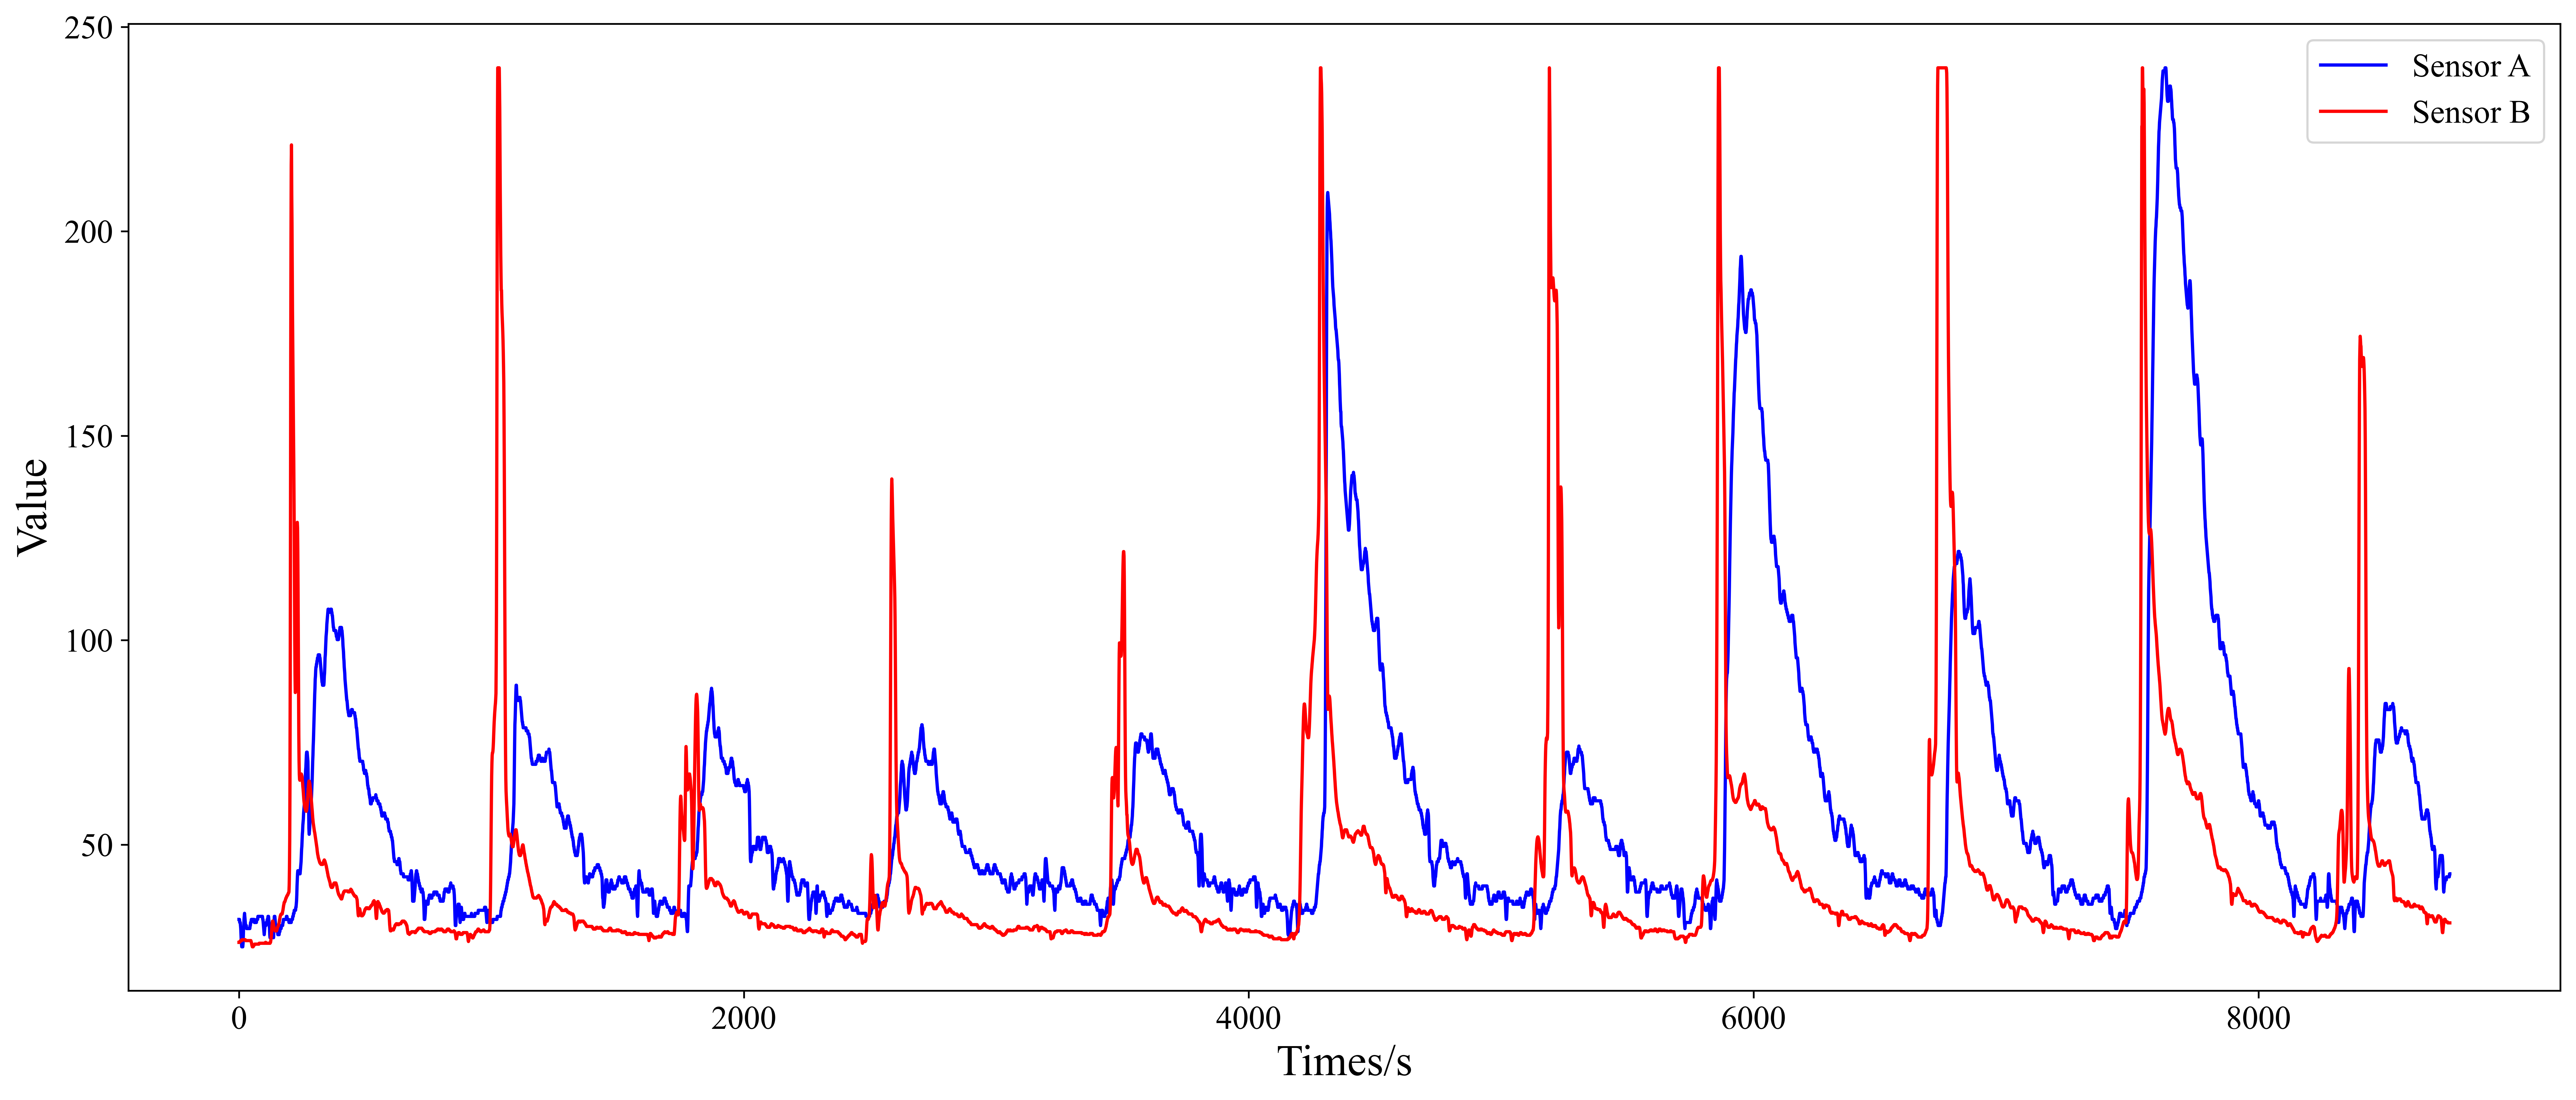

2


In [1]:
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import os


data_path = './data/ft_new'
scaler = preprocessing.MinMaxScaler(feature_range=(25,240))
#scaler = preprocessing.StandardScaler()
real_data = pd.read_csv('{}/real.csv'.format(data_path))
predict_data = pd.read_csv('{}/predict.csv'.format(data_path))
columns = ["time","CO2","TVOC","CH2O","PM2.5","humidity","temperature","PM10","PM1.0","LUX","MCU","noise"]
real_data.sort_index(axis=0,ascending=True)
predict_data.sort_index(axis=0,ascending=True)
predict_data=predict_data.loc[:,["PM2.5"]]

predict_data = scaler.fit_transform(predict_data.loc[:,["PM2.5"]])
real_data = scaler.fit_transform(real_data.loc[:,["PM2.5"]])

#predict_data = scaler.fit_transform(predict_data[7555:8151]) #7560-8156
#test=pd.DataFrame(data=predict_data)#将数据放进表格
#test.to_csv('./data/ft_data_origin/11.csv') #数据存入csv,存储位置及文件名称

""" split_rr = int(predict_data.shape[0]//10)
predict_data = predict_data[9*split_rr:]

split_rr = int(predict_data.shape[0]//10)
xx = np.array(range(0,predict_data.shape[0],1))
predict_data1 = predict_data[:8*split_rr] """
""" xx1 = xx[:8*split_rr]
xx2 = xx[8*split_rr:] """
xx = np.array(range(0,predict_data.shape[0],1))


yy1 = predict_data

yy2 = real_data
#print(xx.shape,yy.shape)
plt.figure(dpi=600,figsize=(15,8))
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams.update({"font.size":15})
plt.xlabel("Times/s",fontdict={'size':20})
plt.ylabel("Value",fontdict={'size':20})
plt.plot(xx,yy1,c='b',label="Sensor A")
plt.plot(xx,yy2,c='red',linestyle='-',label="Sensor B")
plt.legend()
plt.show()

print(5//2)

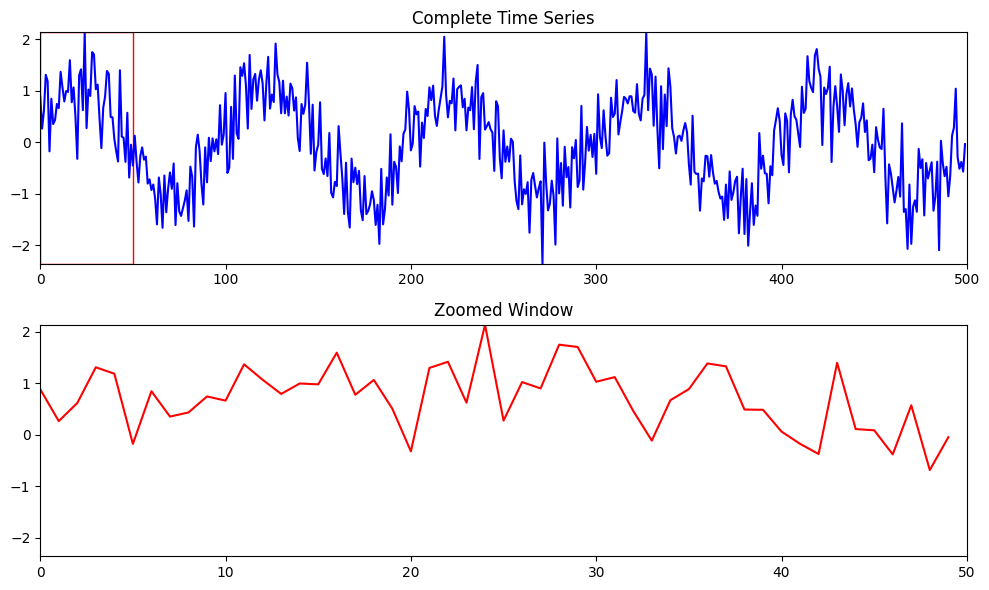

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 生成示例时序数据
np.random.seed(0)
data = np.sin(np.linspace(0, 10 * np.pi, 500)) + np.random.normal(0, 0.5, 500)

# 设置窗口的大小和移动步长
window_size = 50
step_size = 5

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# 绘制完整的时序数据
ax1.plot(data, color='blue')
window_rect = plt.Rectangle((0, min(data)), window_size, max(data) - min(data), edgecolor='red', facecolor='none')
ax1.add_patch(window_rect)
ax1.set_title('Complete Time Series')
ax1.set_xlim([0, len(data)])
ax1.set_ylim([min(data), max(data)])

# 设置下方放大的窗口
line, = ax2.plot(data[:window_size], color='red')
ax2.set_title('Zoomed Window')
ax2.set_xlim([0, window_size])
ax2.set_ylim([min(data), max(data)])

# 更新函数
def update(frame):
    start = frame * step_size
    end = start + window_size
    window_rect.set_x(start)
    line.set_ydata(data[start:end])
    return window_rect, line

# 动画设置
ani = animation.FuncAnimation(fig, update, frames=range((len(data) - window_size) // step_size), blit=True, interval=100)

plt.tight_layout()
plt.show()

下面是画图的

In [ ]:

import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
# plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['Times New Roman']   #设置简黑字体
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
matplotlib.use('Agg')
# %matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
def plot(filename,Pr_value,Ac_value,Time=None):
	save_folder = os.path.join('./fig/exchange-rate/fig240420_test1', filename)
	# save_folder = os.path.join('./fig/traffic/fig240420_test1', filename)
	if not os.path.exists(save_folder):
		os.makedirs(save_folder)
        # print("save_folder is not exit!")
    # model_path = os.path.join(save_folder,'best-model.pt')
	x=range(len(Ac_value[:, 0]))

	for i in range(len(Ac_value[0,:])):
		y_pred=pd.Series(np.array(Pr_value[:,i]))
		y = pd.Series(np.array(Ac_value[:,i]))
		# y_pred= y
		resid = (y - y_pred) / y  # 相对误差
		colors = [(34 / 255, 82 / 255, 127 / 255), (240 / 255, 70 / 255, 67 / 255)]
		fig=plt.figure(i,figsize=(10,6),dpi=500)
		gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1.5])
		ax1 = fig.add_subplot(gs[0])
		ax1.plot(x,Ac_value[:,i],"-",color=colors[0],label="Truth", linewidth=3)
		ax1.plot(x,Pr_value[:,i],'-',color=colors[1],label="Prediction",linewidth=3)
		ax1.set_xlabel("Time", fontdict={'family': 'Times New Roman', 'size': 22})
		ax1.set_ylabel("Value", fontdict={'family': 'Times New Roman', 'size': 22})
		# 设置x轴刻度标签
		plt.xticks(fontproperties='Times New Roman', size=20)
		plt.yticks(fontproperties='Times New Roman', size=20)
		ax1.set_xlim(-10, 1526)
		# plt.ylim(0, 0.66)
		ax1.legend(loc="upper right", fontsize='x-large', prop={'family': 'Times New Roman', 'size': 20},
				   frameon=False, markerscale=1, handlelength=1)
		# 添加第二个子图，占20%
		ax2 = fig.add_subplot(gs[1])
		ax2.plot(x, [resid[idx] for idx in x], color=colors[0], linewidth=3)
		ax2.set_ylabel('Relative error', fontdict={'family': 'Times New Roman', 'size': 22})
		ax2.set_xlabel("Time", fontdict={'family': 'Times New Roman', 'size': 22})
		plt.yticks(fontproperties='Times New Roman', size=20)  # [2,5,10,15,20,25,],
		plt.xticks(fontproperties='Times New Roman', size=20)
		ax2.tick_params(axis='both', which='major', labelsize=20)
		# ax2.set_xlim(-10, 1526)
		# 设置刻度范围
		# ax1.set_xlim(-0.1, 590)
		# ax1.set_ylim(-0.2, 32)
		# ax2.set_xlim(-0.1, 590)
		# ax2.set_ylim(-0.33, +0.18)

		# 对齐y轴标签
		fig.align_ylabels()

		plt.tight_layout()

		plt.savefig('./{}/savefig_example{}-{}.svg'.format(save_folder,filename,str(i)),bbox_inches='tight',dpi=1200)
		plt.show()
	# 关闭所有窗口
	plt.close('all')



[21.1066205  10.36739375  0.21694225 ...  0.034386   -0.318817
  8.5918795 ]


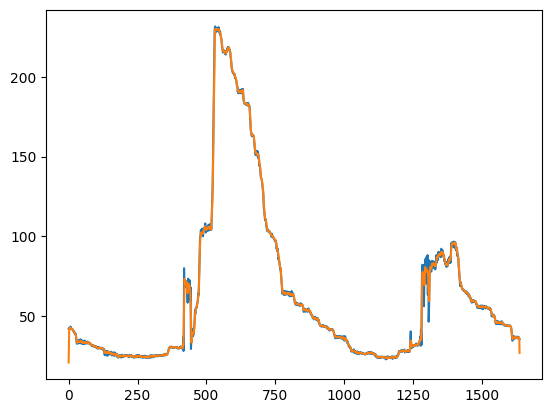

In [42]:
import numpy
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import os
from src.utils.scaler import StandardScaler
import matplotlib
import matplotlib.pyplot as plt

a = pd.read_csv('./data/ft_new/11.csv')
a = np.array(a,dtype=float)[:,1]

x_axis = range(0,len(a))
a_x=np.convolve(a, np.ones((4,))/4, mode='same')
print(a-a_x)
plt.plot(x_axis,a)
plt.plot(x_axis,a_x)

plt.show()

#numpy.convolve(a, v, mode='same')